In [1]:
import datetime

import matplotlib.pyplot as plt
from esm import Alphabet, pretrained
import torch
from tqdm import tqdm
import pandas as pd
import numpy as np
import scipy.stats as ss
from prettytable import PrettyTable

from scipy.special import softmax

import requests as r
from Bio import SeqIO
from io import StringIO
    

In [2]:
# # Load sequence to run DMS study over
# cID = 'P0DTC2'

# baseUrl = "http://www.uniprot.org/uniprot/"
# currentUrl = baseUrl+cID+".fasta"
# response = r.post(currentUrl)
# cData = ''.join(response.text)

# Seq=StringIO(cData)
# pSeq=SeqIO.parse(Seq,'fasta')

# # Truncate seqence so that ESM model accepts it: 
# sequence = pSeq[0].seq[0:1024]
# data = [("Sars_Cov_2", sequence)]

# Just the RBD part of the sequence
# sequence = 'RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNF' # From the UniProt website
sequence = 'NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST' # from the Dataframe
data = [("Sars_Cov_2", sequence)]

In [4]:
# Make list of models to run DMS with
models = ['esm1v_t33_650M_UR90S_'+str(i) for i in range(1,6) ] 
#models = ['esm1v_t33_650M_UR90S_1', 'esm1v_t33_650M_UR90S_2', 'esm1v_t33_650M_UR90S_3', 'esm1v_t33_650M_UR90S_4', 'esm1v_t33_650M_UR90S_5']

In [5]:
# Import csv file containing relvant mutations
url = "https://media.githubusercontent.com/media/jbloomlab/SARS-CoV-2-RBD_DMS/master/results/single_mut_effects/single_mut_effects.csv"
cov_df = pd.read_csv(url)
real_seq = {}
for i,aa in cov_df.iterrows():
    real_seq[aa["site_RBD"]] = aa["wildtype"]
print("".join(real_seq.values()))

NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST


In [6]:
# # Reorder cov_df in terms of effect and absolute position, remove extraneous index column
# cov_df = cov_df.sort_values(['site_SARS2','mutation'])
# cov_df = cov_df.reset_index()
# cov_df.drop("index",axis=1)

# Reorder cov_df in terms of effect and RBD position, remove extraneous index column
cov_df = cov_df.sort_values(['site_RBD','mutation'])
cov_df = cov_df.reset_index()
cov_df.drop("index",axis=1)

,site_RBD,site_SARS2,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg
0,1,331,N,*,N331*,N1*,NaN,NaN,NaN,-4.66,-4.60,-4.63
1,1,331,N,A,N331A,N1A,-0.05,-0.02,-0.03,-0.14,-0.08,-0.11
2,1,331,N,C,N331C,N1C,-0.08,-0.10,-0.09,-1.56,-0.97,-1.26
3,1,331,N,D,N331D,N1D,0.00,0.07,0.03,-0.75,-0.12,-0.44
4,1,331,N,E,N331E,N1E,0.02,-0.02,0.00,-0.39,-0.24,-0.31
...,...,...,...,...,...,...,...,...,...,...,...,...
4216,201,531,T,S,T531S,T201S,0.02,0.00,0.01,0.06,-0.02,0.02
4217,201,531,T,T,T531T,T201T,0.00,0.00,0.00,0.00,0.00,0.00
4218,201,531,T,V,T531V,T201V,0.03,-0.02,0.01,-0.07,-0.05,-0.06
4219,201,531,T,W,T531W,T201W,0.02,-0.06,-0.02,-0.13,-0.04,-0.08


In [7]:
# Sanity check cov_df by printing it
cov_df

,index,site_RBD,site_SARS2,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg
0,20,1,331,N,*,N331*,N1*,NaN,NaN,NaN,-4.66,-4.60,-4.63
1,0,1,331,N,A,N331A,N1A,-0.05,-0.02,-0.03,-0.14,-0.08,-0.11
2,1,1,331,N,C,N331C,N1C,-0.08,-0.10,-0.09,-1.56,-0.97,-1.26
3,2,1,331,N,D,N331D,N1D,0.00,0.07,0.03,-0.75,-0.12,-0.44
4,3,1,331,N,E,N331E,N1E,0.02,-0.02,0.00,-0.39,-0.24,-0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4216,4215,201,531,T,S,T531S,T201S,0.02,0.00,0.01,0.06,-0.02,0.02
4217,4216,201,531,T,T,T531T,T201T,0.00,0.00,0.00,0.00,0.00,0.00
4218,4217,201,531,T,V,T531V,T201V,0.03,-0.02,0.01,-0.07,-0.05,-0.06
4219,4218,201,531,T,W,T531W,T201W,0.02,-0.06,-0.02,-0.13,-0.04,-0.08


In [31]:
# Model eval activates/deactivates the relevant layers for running the network. See this stack exchange answer for a
# slightly more coherent description: https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch
torch.hub.set_dir("../T4Lys/models") # modify location for different machines

# Loop over the models
for mod in models: 
    
    model, alphabet = pretrained.load_model_and_alphabet(mod)
    model.eval()
    if torch.cuda.is_available():
        model = model.cuda()
        print("Transferred model to GPU")
    
    # Load batch converters
    batch_converter = alphabet.get_batch_converter()
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    
    # Conduct DMS study for the given model
    dms = pd.DataFrame()
    for i in tqdm(range(batch_tokens.size(1))):
        batch_tokens_masked = batch_tokens.clone()
        batch_tokens_masked[0, i] = alphabet.mask_idx
        with torch.no_grad():
            token_probs = torch.log_softmax(
                #model(batch_tokens_masked)["logits"], dim=-1 # if gpu not available, use this
                model(batch_tokens_masked.cuda())["logits"], dim=-1
            )
        col = pd.DataFrame(token_probs[:, i].cpu())
        col = col.transpose()
        dms = pd.concat([dms,col],axis=1)
        
    # Relabel indices
    idx_map = {0: '<cls>', 1: '<pad>', 2: '<eos>', 3: '<unk>', 4: 'L', 5: 'A', 6: 'G', 7: 'V', 8: 'S', 9: 'E', 10: 'R', 11: 'T', 12: 'I', 13: 'D', 14: 'P', 15: 'K', 16: 'Q', 17: 'N', 18: 'F', 19: 'Y', 20: 'M', 21: 'H', 22: 'W', 23: 'C', 24: 'X', 25: 'B', 26: 'U', 27: 'Z', 28: 'O', 29: '.', 30: '-', 31: '<null_1>', 32: '<mask>'}
    dms = dms.rename(index = idx_map)
    
    # Relabel Columns
    new_col = list(sequence)
    new_col.append('<eos>')
    new_col.insert(0,'<cls>')
    dms.columns = new_col
    
    # Delete extraneous predictions and rare amino acids from DMS dataframe. Delete eos and cls token form sequence
    dms = dms.drop(index = ['<cls>','<pad>','<unk>','.','-','<null_1>','<mask>','X','B','U','Z','O'])
    dms = dms.drop(columns = ['<cls>','<eos>']) # DMS now has dimensions L x 20+1
    
    # Save DMS matrix
    dms.to_csv("dms_cov_esm_"+str(models.index(mod))+"_on_"+str(datetime.datetime.now()).split(".")[0].replace(":","_").replace(" ","_at_")+".csv")
    
    # Isolate the Pseudoenergies of the relevant mutations
    cov_df["logP_mut_"+mod] = ""
    cov_df["logP_wt_"+mod] = ""
    cov_df["log_mut_minus_wt_vals_"+mod] = ""
    for i, row in cov_df.iterrows():
        #wt, idx, mt = row["wildtype"], int(row["site_SARS2"]), row["mutant"] # Absolute index
        wt, idx, mt = row["wildtype"], int(row["site_RBD"]), row["mutant"] # Domain index
        assert dms.columns.values.tolist()[idx-1] == wt,  "Wildtype at index "+str(i)+" does not match provided mutation"
        mut_pseudo_e = float(pd.DataFrame(dms.iloc[:, idx-1]).loc[mt if mt != '*' else '<eos>'])
        wt_pseudo_e = float(pd.DataFrame(dms.iloc[:, idx-1]).loc[wt])
        cov_df.loc[i,"logP_mut_"+mod] = mut_pseudo_e 
        cov_df.loc[i,"logP_wt_"+mod]  = wt_pseudo_e
        cov_df.loc[i,"log_mut_minus_wt_vals_"+mod] = float(mut_pseudo_e - wt_pseudo_e)
    
    print("Finished running "+mod)

/gscratch/spe/uwagura/miniconda3/envs/prot_analysis_env/lib/python3.10/site-packages/esm/pretrained.py:148: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


Transferred model to GPU


100%|█████████████████████| 203/203 [00:06<00:00, 33.73it/s]


Finished running esm1v_t33_650M_UR90S_1


/gscratch/spe/uwagura/miniconda3/envs/prot_analysis_env/lib/python3.10/site-packages/esm/pretrained.py:148: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


Transferred model to GPU


100%|█████████████████████| 203/203 [00:06<00:00, 33.76it/s]


Finished running esm1v_t33_650M_UR90S_2


/gscratch/spe/uwagura/miniconda3/envs/prot_analysis_env/lib/python3.10/site-packages/esm/pretrained.py:148: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


Transferred model to GPU


100%|█████████████████████| 203/203 [00:06<00:00, 33.61it/s]


Finished running esm1v_t33_650M_UR90S_3


/gscratch/spe/uwagura/miniconda3/envs/prot_analysis_env/lib/python3.10/site-packages/esm/pretrained.py:148: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


Transferred model to GPU


100%|█████████████████████| 203/203 [00:05<00:00, 33.99it/s]


Finished running esm1v_t33_650M_UR90S_4


/gscratch/spe/uwagura/miniconda3/envs/prot_analysis_env/lib/python3.10/site-packages/esm/pretrained.py:148: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


Transferred model to GPU


100%|█████████████████████| 203/203 [00:06<00:00, 33.67it/s]


Finished running esm1v_t33_650M_UR90S_5


In [32]:
# Sanity check: Print out cov_df
cov_df

,level_0,index,site_RBD,site_SARS2,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,...,log_mut_minus_wt_vals_esm1v_t33_650M_UR90S_2,logP_mut_esm1v_t33_650M_UR90S_3,logP_wt_esm1v_t33_650M_UR90S_3,log_mut_minus_wt_vals_esm1v_t33_650M_UR90S_3,logP_mut_esm1v_t33_650M_UR90S_4,logP_wt_esm1v_t33_650M_UR90S_4,log_mut_minus_wt_vals_esm1v_t33_650M_UR90S_4,logP_mut_esm1v_t33_650M_UR90S_5,logP_wt_esm1v_t33_650M_UR90S_5,log_mut_minus_wt_vals_esm1v_t33_650M_UR90S_5
0,0,20,1,331,N,*,N331*,N1*,NaN,NaN,...,-17.625334,-22.566446,-4.529651,-18.036796,-22.507938,-3.906369,-18.601569,-21.789116,-4.057635,-17.731481
1,1,0,1,331,N,A,N331A,N1A,-0.05,-0.02,...,0.11722,-4.627549,-4.529651,-0.097898,-3.769818,-3.906369,0.136551,-4.067891,-4.057635,-0.010256
2,2,1,1,331,N,C,N331C,N1C,-0.08,-0.10,...,-1.155027,-5.343649,-4.529651,-0.813999,-4.836605,-3.906369,-0.930235,-5.03289,-4.057635,-0.975255
3,3,2,1,331,N,D,N331D,N1D,0.00,0.07,...,-0.111874,-4.552698,-4.529651,-0.023047,-3.910919,-3.906369,-0.004549,-3.957612,-4.057635,0.100023
4,4,3,1,331,N,E,N331E,N1E,0.02,-0.02,...,-0.496364,-4.993572,-4.529651,-0.463921,-4.452884,-3.906369,-0.546514,-4.305532,-4.057635,-0.247896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4216,4216,4215,201,531,T,S,T531S,T201S,0.02,0.00,...,0.283327,-2.4129,-2.660855,0.247955,-2.368068,-2.729167,0.361099,-2.347842,-2.710834,0.362992
4217,4217,4216,201,531,T,T,T531T,T201T,0.00,0.00,...,0.0,-2.660855,-2.660855,0.0,-2.729167,-2.729167,0.0,-2.710834,-2.710834,0.0
4218,4218,4217,201,531,T,V,T531V,T201V,0.03,-0.02,...,-0.209101,-2.852065,-2.660855,-0.19121,-2.909372,-2.729167,-0.180206,-2.893387,-2.710834,-0.182553
4219,4219,4218,201,531,T,W,T531W,T201W,0.02,-0.06,...,-1.863883,-4.316953,-2.660855,-1.656098,-4.460578,-2.729167,-1.731412,-4.194947,-2.710834,-1.484113


In [5]:
# If it looks good, save it: 
cov_df.to_csv("Sars_cov_w_with_dms_for_all_esm.csv")

NameError: name 'cov_df' is not defined

In [8]:
# If remaking plots without rerunning models, start here: 
cov_df = pd.read_csv("dms/Sars_cov_w_with_dms_for_all_esm.csv")

In [27]:
print(cov_df.columns)
cov_df

Index(['Unnamed: 0', 'level_0', 'index', 'site_RBD', 'site_SARS2', 'wildtype',
       'mutant', 'mutation', 'mutation_RBD', 'bind_lib1', 'bind_lib2',
       'bind_avg', 'expr_lib1', 'expr_lib2', 'expr_avg',
       'logP_mut_esm1v_t33_650M_UR90S_1', 'logP_wt_esm1v_t33_650M_UR90S_1',
       'log_mut_minus_wt_vals_esm1v_t33_650M_UR90S_1',
       'logP_mut_esm1v_t33_650M_UR90S_2', 'logP_wt_esm1v_t33_650M_UR90S_2',
       'log_mut_minus_wt_vals_esm1v_t33_650M_UR90S_2',
       'logP_mut_esm1v_t33_650M_UR90S_3', 'logP_wt_esm1v_t33_650M_UR90S_3',
       'log_mut_minus_wt_vals_esm1v_t33_650M_UR90S_3',
       'logP_mut_esm1v_t33_650M_UR90S_4', 'logP_wt_esm1v_t33_650M_UR90S_4',
       'log_mut_minus_wt_vals_esm1v_t33_650M_UR90S_4',
       'logP_mut_esm1v_t33_650M_UR90S_5', 'logP_wt_esm1v_t33_650M_UR90S_5',
       'log_mut_minus_wt_vals_esm1v_t33_650M_UR90S_5', 'Avg_delta_log',
       'Diff_log_sum_probs'],
      dtype='object')


,Unnamed: 0,level_0,index,site_RBD,site_SARS2,wildtype,mutant,mutation,mutation_RBD,bind_lib1,...,logP_wt_esm1v_t33_650M_UR90S_3,log_mut_minus_wt_vals_esm1v_t33_650M_UR90S_3,logP_mut_esm1v_t33_650M_UR90S_4,logP_wt_esm1v_t33_650M_UR90S_4,log_mut_minus_wt_vals_esm1v_t33_650M_UR90S_4,logP_mut_esm1v_t33_650M_UR90S_5,logP_wt_esm1v_t33_650M_UR90S_5,log_mut_minus_wt_vals_esm1v_t33_650M_UR90S_5,Avg_delta_log,Diff_log_sum_probs
0,0,0,20,1,331,N,*,N331*,N1*,NaN,...,-4.529651,-18.036796,-22.507938,-3.906369,-18.601569,-21.789116,-4.057635,-17.731481,-18.264260,-18.108782
1,1,1,0,1,331,N,A,N331A,N1A,-0.05,...,-4.529651,-0.097898,-3.769818,-3.906369,0.136551,-4.067891,-4.057635,-0.010256,0.023908,0.040604
2,2,2,1,1,331,N,C,N331C,N1C,-0.08,...,-4.529651,-0.813999,-4.836605,-3.906369,-0.930235,-5.032890,-4.057635,-0.975255,-0.973428,-0.970800
3,3,3,2,1,331,N,D,N331D,N1D,0.00,...,-4.529651,-0.023047,-3.910919,-3.906369,-0.004549,-3.957612,-4.057635,0.100023,-0.060007,-0.041074
4,4,4,3,1,331,N,E,N331E,N1E,0.02,...,-4.529651,-0.463921,-4.452884,-3.906369,-0.546514,-4.305532,-4.057635,-0.247896,-0.461127,-0.450366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4216,4216,4216,4215,201,531,T,S,T531S,T201S,0.02,...,-2.660855,0.247955,-2.368068,-2.729167,0.361099,-2.347842,-2.710834,0.362992,0.313442,0.312833
4217,4217,4217,4216,201,531,T,T,T531T,T201T,0.00,...,-2.660855,0.000000,-2.729167,-2.729167,0.000000,-2.710834,-2.710834,0.000000,0.000000,0.000000
4218,4218,4218,4217,201,531,T,V,T531V,T201V,0.03,...,-2.660855,-0.191210,-2.909372,-2.729167,-0.180206,-2.893387,-2.710834,-0.182553,-0.165460,-0.165141
4219,4219,4219,4218,201,531,T,W,T531W,T201W,0.02,...,-2.660855,-1.656098,-4.460578,-2.729167,-1.731412,-4.194947,-2.710834,-1.484113,-1.660969,-1.656908


In [9]:
# ---------------------------------- Calculate overlap between model predictions and Data -------------------------
# Get model bind_avg, and expr_ave for mutations of interest
bind_avg = np.array(cov_df["bind_avg"])
expr_avg = np.array(cov_df["expr_avg"])

# Get sites with nan value
bind_nan = ~np.isnan(bind_avg)
expr_nan = ~np.isnan(expr_avg)
    
# Calculate vector correlation for each model's prediction
correlations = pd.DataFrame()
for mod in models:
    mod_preds = np.array(cov_df["log_mut_minus_wt_vals_"+mod])
    
    # Get spearmen r:
    spearmenr_bind,p_bind = ss.spearmanr(bind_avg,mod_preds,nan_policy="omit")
    spearmenr_expr,p_expr = ss.spearmanr(expr_avg,mod_preds,nan_policy="omit")
    print(mod+" spearman r and p for bind_avg: ",spearmenr_bind,p_bind)
    print(mod+" spearman r and p for bind_avg: ",spearmenr_expr,p_expr)
    print("\n")    
    
    # Get dot products
    dot_bind = np.dot(bind_avg[bind_nan],mod_preds[bind_nan])
    dot_expr = np.dot(expr_avg[expr_nan],mod_preds[expr_nan])
    
    # Normalize dot product
    dot_bind /= (np.linalg.norm(bind_avg[bind_nan])*np.linalg.norm(mod_preds[bind_nan]))
    dot_expr /= (np.linalg.norm(expr_avg[expr_nan])*np.linalg.norm(mod_preds[expr_nan]))
    
    # dot_bind = np.dot(bind_avg,mod_preds)
    # dot_expr = np.dot(expr_avg,mod_preds)
    
    print(mod+" cos(theta) for bind_avg: ",dot_bind)
    print(mod+" cos(theta) and p for bind_avg: ",dot_expr)
    print("\n")


esm1v_t33_650M_UR90S_1 spearman r and p for bind_avg:  -0.005308077898577856 0.7370702041794203
esm1v_t33_650M_UR90S_1 spearman r and p for bind_avg:  0.1514912240918074 5.644375529447678e-23


esm1v_t33_650M_UR90S_1 cos(theta) for bind_avg:  0.1544385854408272
esm1v_t33_650M_UR90S_1 cos(theta) and p for bind_avg:  0.5855037610984136


esm1v_t33_650M_UR90S_2 spearman r and p for bind_avg:  -0.03706114845112351 0.01903193450591857
esm1v_t33_650M_UR90S_2 spearman r and p for bind_avg:  0.13389168251202851 2.991558524253387e-18


esm1v_t33_650M_UR90S_2 cos(theta) for bind_avg:  0.15375477027047593
esm1v_t33_650M_UR90S_2 cos(theta) and p for bind_avg:  0.5887147869673492


esm1v_t33_650M_UR90S_3 spearman r and p for bind_avg:  0.0040048764277434866 0.8000306224863274
esm1v_t33_650M_UR90S_3 spearman r and p for bind_avg:  0.15755266204187973 9.68998608043039e-25


esm1v_t33_650M_UR90S_3 cos(theta) for bind_avg:  0.1798399437392439
esm1v_t33_650M_UR90S_3 cos(theta) and p for bind_avg:  0.590

In [17]:
# # Plot prob vector from average pseudo energy at each site: 
# fig,ax = plt.subplots(1,2,figsize=(10,10),dpi=300,gridspec_kw={'width_ratios': [1, 1]})

# Method 1: Take the average of the (logP_mut - logP_wt) values from each model
method_1 = []
for i,row in cov_df.iterrows():
    method_1.append( ((row['log_mut_minus_wt_vals_esm1v_t33_650M_UR90S_1'])+
                                   (row['log_mut_minus_wt_vals_esm1v_t33_650M_UR90S_2'])+
                                   (row['log_mut_minus_wt_vals_esm1v_t33_650M_UR90S_3'])+
                                   (row['log_mut_minus_wt_vals_esm1v_t33_650M_UR90S_4'])+
                                   (row['log_mut_minus_wt_vals_esm1v_t33_650M_UR90S_5']))/5
                        ) 

method_1= np.array(method_1)

# # Plot the vector
# method_1 = method_1.reshape(4221,1) # note that the imshow function expects a vector with more than one dimension
# im1 = ax[0].imshow(method_1,cmap='RdBu')
# ax[0].set_title(r'$\frac{1}{5} \sum(\logP_{mut} - \logP_{wt}) $')
# ax[0].set_xticks([])
# ax[0].set_yticks(range(len(cov_df[[x for x in cov_df.columns if 'mut_struct_prob_diff' in x]])))
# ax[0].set_yticklabels(labels=zip(cov_df['variant'].to_numpy(),cov_df['effect'].to_numpy()))
# fig.colorbar(im1, ax=ax[0],orientation='vertical', aspect=1, pad=0.1)
# me_sum = method_1

# Method 2: Take the log of the averaage P_mut, subtract the log of the average P_wt 
method_2 = []
for i,row in cov_df.iterrows():
    method_2.append( np.log( (np.exp(row['logP_mut_esm1v_t33_650M_UR90S_1'])+
                                np.exp(row['logP_mut_esm1v_t33_650M_UR90S_2'])+
                                np.exp(row['logP_mut_esm1v_t33_650M_UR90S_3'])+
                                np.exp(row['logP_mut_esm1v_t33_650M_UR90S_4'])+
                                np.exp(row['logP_mut_esm1v_t33_650M_UR90S_5']))
                            / 
                            (np.exp(row['logP_wt_esm1v_t33_650M_UR90S_1'])+
                                    np.exp(row['logP_wt_esm1v_t33_650M_UR90S_2'])+
                                    np.exp(row['logP_wt_esm1v_t33_650M_UR90S_3'])+
                                    np.exp(row['logP_wt_esm1v_t33_650M_UR90S_4'])+
                                    np.exp(row['logP_wt_esm1v_t33_650M_UR90S_5']))
                                 )
                         )


method_2= np.array(method_2)

# # Plot the second vector
# method_2 = method_2.reshape(4221,1)
# im1 = ax[1].imshow(method_2,cmap='RdBu')
# ax[1].set_title(r'$ \log(\frac{1}{5}\sum P_{mut}) - \log(\frac{1}{5}\sum P_{wt}) $')
# ax[1].set_xticks([])
# ax[1].set_yticks(range(len(t4_df[[x for x in t4_df.columns if 'mut_struct_prob_diff' in x]])))
# ax[1].set_yticklabels(labels=zip(cov_df['variant'].to_numpy(),cov_df['effect'].to_numpy()))
# fig.colorbar(im1, ax=ax[1],orientation='vertical', aspect=1, pad=0.1)
# # plt.savefig('plots/T4_mutant_log_differences_wt_structures.pdf')
# plt.show()
# me_log = method_2

In [18]:
# Add combined results to T4_df
cov_df["Avg_delta_log"] = method_1
cov_df["Diff_log_sum_probs"] = method_2

# Save combine dataframe
# cov_df.to_csv("t4_df_with_averages.csv")

+--------+----------------------+-------------------+
| Method |      Spearman R      |      P-Value      |
+--------+----------------------+-------------------+
|   1    | -0.01053771734059171 | 0.505076278263318 |
|   2    | -0.01053771734059171 | 0.505076278263318 |
+--------+----------------------+-------------------+


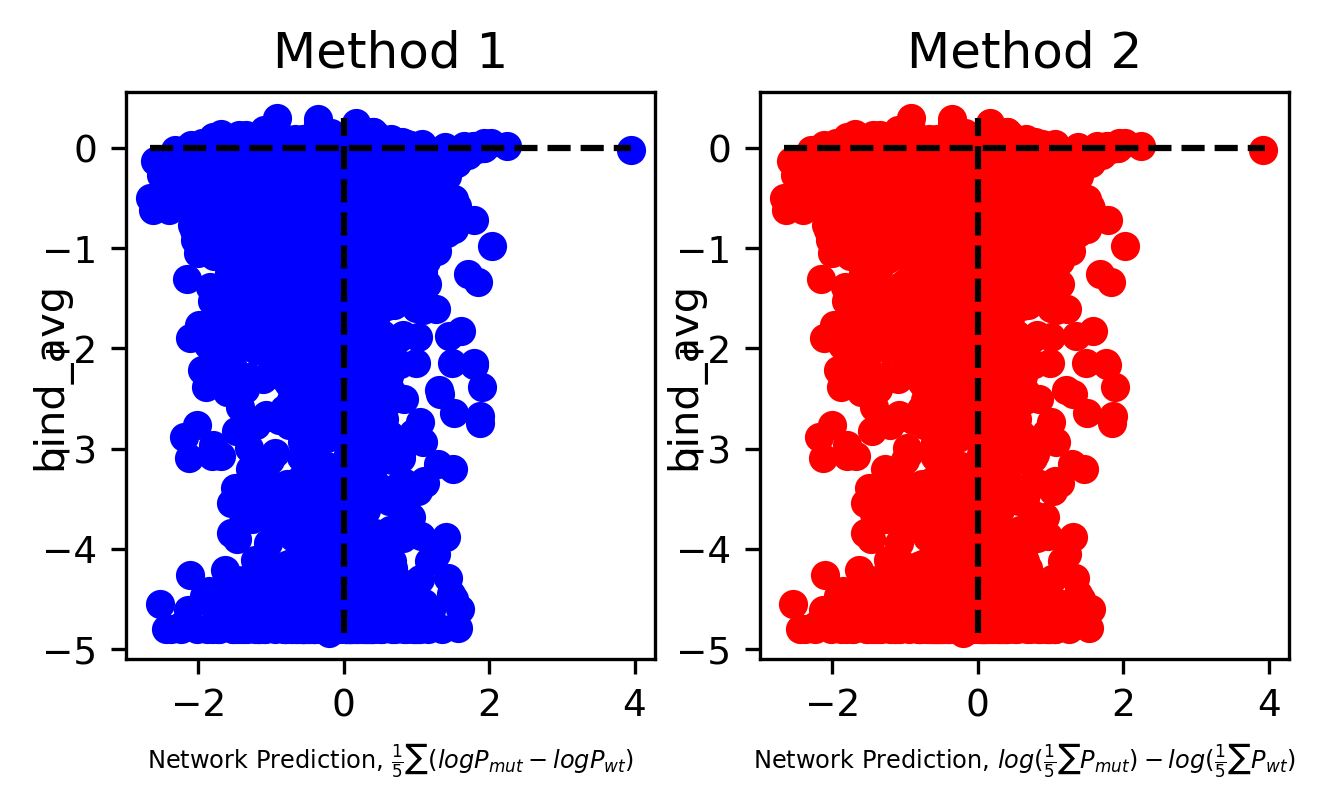

In [28]:
# Calculate Correlations between 
cov_df_no_nan = cov_df[~np.isnan(cov_df["bind_avg"])]
delta_delta_G = cov_df_no_nan["bind_avg"]
method_1_no_nan = cov_df_no_nan["Avg_delta_log"]
method_2_no_nan = cov_df_no_nan["Diff_log_sum_probs"]

avg_delt_log_rho,avg_delt_log_p = ss.spearmanr(delta_delta_G,method_1_no_nan)
diff_log_sum_rho,diff_log_sum_p = ss.spearmanr(delta_delta_G,method_1_no_nan)

# Plot correlations
fig,ax = plt.subplots(1,2,figsize=(5,2.5),dpi=300,gridspec_kw={'width_ratios': [1, 1]})

# Get minimum values of each array for plotting vertical and horizontal lines
min_x  = min(method_1_no_nan)
max_x = max(method_1_no_nan)
min_y  = min(delta_delta_G)
max_y = max(delta_delta_G)

# Method 1
ax[0].plot(method_1_no_nan, delta_delta_G, 'bo')
ax[0].set_title("Method 1")
ax[0].hlines(0, min_x, max_x, colors = '00', linestyles = "dashed" )
ax[0].vlines(0, min_y, max_y, colors = '00', linestyles = "dashed" )
ax[0].tick_params(labelsize = 9)
ax[0].set_xlabel(r"Network Prediction, $\frac{1}{5} \sum (logP_{mut} -  logP_{wt})$",{'fontsize': 'xx-small'})
ax[0].set_ylabel(r"bind_avg",labelpad = -7)

# Method 2
ax[1].plot(method_2_no_nan, delta_delta_G, 'ro')
ax[1].set_title("Method 2")
ax[1].hlines(0, min_x, max_x, colors = '00', linestyles = "dashed" )
ax[1].vlines(0, min_y, max_y, colors = '00', linestyles = "dashed" )
ax[1].tick_params(labelsize = 9)
ax[1].set_xlabel(r"Network Prediction, $log(\frac{1}{5} \sum P_{mut}) - log(\frac{1}{5} \sum P_{wt})$",{'fontsize': 'xx-small'})
ax[1].set_ylabel(r"bind_avg",labelpad = -7)
#plt.show()

# Display Correlations as table
correlations = PrettyTable(["Method", "Spearman R", "P-Value"])
correlations.add_row(["1", avg_delt_log_rho, avg_delt_log_p])
correlations.add_row(["2", diff_log_sum_rho, diff_log_sum_p])

# plt.savefig("plots/ddG_vs_prediction.jpg")
print(correlations)
# print("For the first method ( taking the average of Delta Log values), the Spearman R value is: ", avg_delt_log_rho, " and the p-value is: ", avg_delt_log_p)
# print("For the second method ( taking the difference of the log sums), the Spearman R value is: ", diff_log_sum_rho, " and the p-value is: ", diff_log_sum_p)


+--------+---------------------+------------------------+
| Method |      Spearman R     |        P-Value         |
+--------+---------------------+------------------------+
|   1    | 0.15280284942155078 | 2.3750324504938668e-23 |
|   2    | 0.15280284942155078 | 2.3750324504938668e-23 |
+--------+---------------------+------------------------+


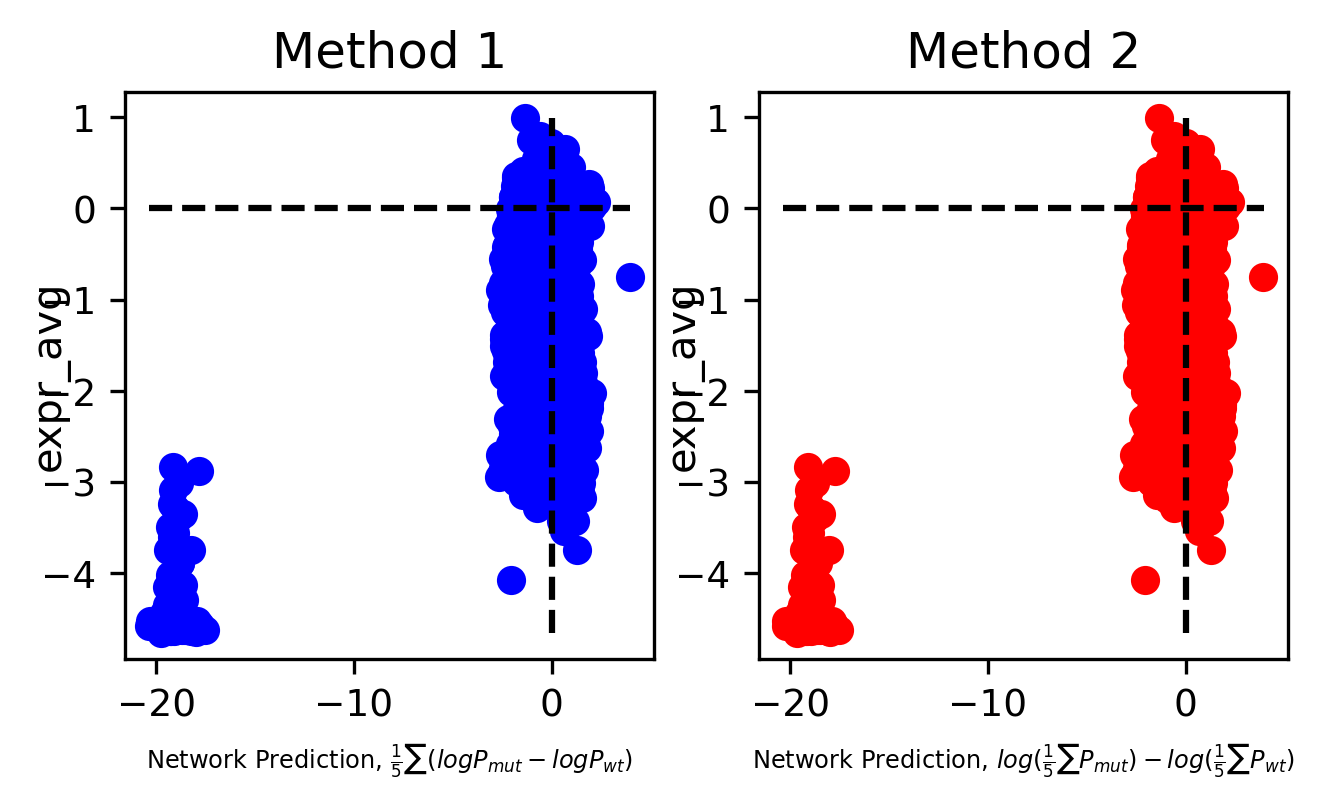

In [29]:
# Calculate Correlations between 
cov_df_no_nan = cov_df[~np.isnan(cov_df["expr_avg"])]
delta_delta_G = cov_df_no_nan["expr_avg"]
method_1_no_nan = cov_df_no_nan["Avg_delta_log"]
method_2_no_nan = cov_df_no_nan["Diff_log_sum_probs"]

avg_delt_log_rho,avg_delt_log_p = ss.spearmanr(delta_delta_G,method_1_no_nan)
diff_log_sum_rho,diff_log_sum_p = ss.spearmanr(delta_delta_G,method_1_no_nan)

# Plot correlations
fig,ax = plt.subplots(1,2,figsize=(5,2.5),dpi=300,gridspec_kw={'width_ratios': [1, 1]})

# Get minimum values of each array for plotting vertical and horizontal lines
min_x  = min(method_1_no_nan)
max_x = max(method_1_no_nan)
min_y  = min(delta_delta_G)
max_y = max(delta_delta_G)

# Method 1
ax[0].plot(method_1_no_nan, delta_delta_G, 'bo')
ax[0].set_title("Method 1")
ax[0].hlines(0, min_x, max_x, colors = '00', linestyles = "dashed" )
ax[0].vlines(0, min_y, max_y, colors = '00', linestyles = "dashed" )
ax[0].tick_params(labelsize = 9)
ax[0].set_xlabel(r"Network Prediction, $\frac{1}{5} \sum (logP_{mut} -  logP_{wt})$",{'fontsize': 'xx-small'})
ax[0].set_ylabel(r"expr_avg",labelpad = -7)

# Method 2
ax[1].plot(method_2_no_nan, delta_delta_G, 'ro')
ax[1].set_title("Method 2")
ax[1].hlines(0, min_x, max_x, colors = '00', linestyles = "dashed" )
ax[1].vlines(0, min_y, max_y, colors = '00', linestyles = "dashed" )
ax[1].tick_params(labelsize = 9)
ax[1].set_xlabel(r"Network Prediction, $log(\frac{1}{5} \sum P_{mut}) - log(\frac{1}{5} \sum P_{wt})$",{'fontsize': 'xx-small'})
ax[1].set_ylabel(r"expr_avg",labelpad = -7)
#plt.show()

# Display Correlations as table
correlations = PrettyTable(["Method", "Spearman R", "P-Value"])
correlations.add_row(["1", avg_delt_log_rho, avg_delt_log_p])
correlations.add_row(["2", diff_log_sum_rho, diff_log_sum_p])

# plt.savefig("plots/ddG_vs_prediction.jpg")
print(correlations)
# print("For the first method ( taking the average of Delta Log values), the Spearman R value is: ", avg_delt_log_rho, " and the p-value is: ", avg_delt_log_p)
# print("For the second method ( taking the difference of the log sums), the Spearman R value is: ", diff_log_sum_rho, " and the p-value is: ", diff_log_sum_p)
